In [545]:
import bpy
import os
import numpy as np
import matplotlib.pyplot as plt
import tempfile
from PIL import Image
import warnings
from helper_functies import *
from IPython.display import Image as JupImage
import imageio
import bmesh
import mathutils
from mathutils import Vector

tmpdir=tempfile.TemporaryDirectory()
size = [960, 1280]
my_dpi = 96 # Afhankelijk van monitor

# Class of objects ========================================================== #
class Object:
    def __init__(self, name, obj, obj_data):
        # Re-Import the converted obj file
        file_loc = 'obj/'+ name[1] + '.obj'
        imported_object = bpy.ops.import_scene.obj(filepath = file_loc)
        self.object = bpy.context.selected_objects[0]
        self.object_data = bpy.data.objects[self.object.name]
    
        # Shadow of object is removed
        self.object.active_material.use_shadeless = True
        
        obj.append(self.object)
        obj_data.append(bpy.data.objects[self.object.name])
        n[0] += 1
        
    def color(self, r, g, b):
        self.object_data.active_material.diffuse_color = (r, g, b)
        self.object_data.active_material.diffuse_intensity = 1
# =========================================================================== #


# Preprocess of an obj ====================================================== #
def pre_obj(name):
    # Import an original obj file
    file_loc = 'obj/' + name[0] + '.obj'
    imported_object = bpy.ops.import_scene.obj(filepath = file_loc)
    
    # Export the obj file
    blend_file_path = bpy.data.filepath
    directory = os.path.dirname(blend_file_path)
    target_file = os.path.join(directory, name[1] + '.obj')
    bpy.ops.export_scene.obj(filepath='obj/' + name[1] + '.obj')

    # Remove a mtl file and the original obj file
    os.remove('obj/' + name[1] + '.mtl')
    bpy.ops.object.delete(use_global = False)
# ==================================================================== #


# Get an image ======================================================= #
def get_img(tmpdir=tmpdir, size=size, name='result'):
    scene = bpy.context.scene
    
    # Set resolution of x and y
    scene.render.resolution_x = size[0]
    scene.render.resolution_y = size[1]
    scene.render.resolution_percentage = 100
    scene.render.filepath=tmpdir.name+"/image"
    
    # Render the image
    bpy.ops.render.render(write_still=True)
    
    # Save the rendered image
    save_loc = "C:/Users/cglab/Anaconda3/envs/blender/RenderingModule/"+name+".png"
    bpy.data.images['Render Result'].save_render(filepath = save_loc)

    # Show the rendered image
    img=Image.open(tmpdir.name+"/image.png")
    return img
# ==================================================================== #


#implement rendering mode ============================================ #
def render_pass(mode, object, n):
    if mode == 'wireframe':
        bpy.context.scene.render.use_freestyle = True
        bpy.context.scene.render.use_edge_enhance = True
        bpy.context.scene.render.edge_threshold = 1
        for i in range (0, n[0]):
            object[i].active_material.diffuse_color = (1, 1, 1)
            object[i].active_material.diffuse_intensity = 1
        
        # choose 'ABSOLUTE' or 'RELATIVE', I recommend 'ABSOLUTE'
        bpy.context.scene.render.line_thickness_mode = 'ABSOLUTE'
        bpy.context.scene.render.line_thickness = 0.5
        bpy.context.scene.world.horizon_color = (1, 1, 1)
        
    elif mode == 'normal':
        for i in range (0, n[0]):
            object[i].active_material.use_shadeless = True
        
            # Please, change a place with mc23.jpg
            realpath = r"C:\Users\cglab\Anaconda3\envs\blender\RenderingModule\mc23.jpg"
            try:
                img = bpy.data.images.load(realpath)
            except:
                raise NameError("Cannot load image %s" % realpath)

            # Create image texture from image
            cTex = bpy.data.textures.new("NORMAL", type='IMAGE')
            cTex.image = img

            # Create material note that it is not same as the "texture"
            mat = bpy.data.materials.new("NORMAL")

            # Add texture slot for color texture
            mtex = mat.texture_slots.add()
            mtex.texture = cTex
            mtex.texture_coords = 'NORMAL'
            mtex.use_map_color_diffuse = True
            mtex.use_map_color_emission = True
            mtex.emission_color_factor = 1.0
            mtex.use_map_density = False
            mtex.mapping = 'FLAT'

            # assign material to object
            object[i].data.materials.append(mat)

            # or overwrite an existing material slot via index operator
            object[i].data.materials[0] = mat
        
    # do not wireframe
    else:
        bpy.context.scene.render.use_freestyle = False
        bpy.context.scene.render.use_edge_enhance = False
# ====================================================================== #


# Class of camera ====================================================== #
class Camera:
    def __init__(self, mode):
        bpy.ops.object.camera_add()
        self.camera_obj = bpy.data.objects['Camera']
        bpy.ops.object.empty_add(
                type='PLAIN_AXES', radius=1, view_align=False,
                location=(0, 0, 0),
                layers=(True, False, False, False, False, False, False,
                        False, False, False, False, False, False, False,
                        False, False, False, False, False, False)
                )
        
        # Perspective or Orthographic
        self.camera_obj.data.type = mode
        
        # Camera tracks to an object
        self.ttc = self.camera_obj.constraints.new(type='TRACK_TO')
        self.ttc.target = bpy.context.selected_objects[0]
        self.ttc.track_axis = 'TRACK_NEGATIVE_Z'
        self.ttc.up_axis = 'UP_Y'    
        
        self.x = 0
        self.y = 0
        self.z = 0
    
    def pos(self, r, theta, phi):
        # Spherical coord. is converted to cartesian coord.
        self.x = r * sin(theta * (math.pi/180)) * cos(phi * (math.pi/180))
        self.y = r * sin(theta * (math.pi/180)) * sin(phi * (math.pi/180))
        self.z = r * cos(theta * (math.pi/180))
    
        # Position of camera
        self.camera_obj.location.x = self.x
        self.camera_obj.location.y = self.y
        self.camera_obj.location.z = self.z

    def intrinsic(self, focal, shift_x, shift_y):
        if self.camera_obj.data.type == 'PERSP':
            self.camera_obj.data.lens = focal
            self.camera_obj.data.shift_x = shift_x
            self.camera_obj.data.shift_y = shift_y
# ============================================================================ #        


# test ========================================== #
def camera_pos(r, theta, phi, mode, degree):
    # 
    camera_obj.constraints[ttc.name].owner_space = 'LOCAL'
    camera_obj.rotation_mode = 'AXIS_ANGLE'
    camera_obj.rotation_axis_angle[0] = degree * (math.pi/180)
    camera_obj.rotation_axis_angle[1] = 1    
    camera_obj.rotation_axis_angle[2] = 1    
    camera_obj.rotation_axis_angle[3] = 1    
# ====================================================================== #

In [550]:
zero(my_dpi)
# Set the light, RECOMMENDED TYPE :  SUN or POINT 
bpy.ops.object.lamp_add(type='SUN',location=(5,2,1))

#Set the environment lighting and the color of background
bpy.context.scene.world.light_settings.use_environment_light = True
bpy.context.scene.world.horizon_color = (0, 0, 0)    # the color of background

# obj and the # of objects
obj = []
obj_data = []
n = [0]

# Preprocess of obj file
name_1 = ['chair braket(4ea)', 'chair braket(4ea)_b']    # name (before, after)
pre_obj(name_1)
name_2 = ['chair braket(4ea)', 'chair braket(4ea)_b2']
pre_obj(name_2)

# Object's location, rotation, scale, and color
obj1 = Object(name_1, obj, obj_data)
obj1.object.location = (0, 0, 0)    # location (x, y, z)
#obj1.rotation_euler = (0, 0, 0)
obj1.object.scale = (15, 15, 15)    # scale (x, y, z)
obj1.color(1, 1, 1)    # color (r, g, b)

obj2 = Object(name_2, obj, obj_data)
obj2.object.location = (-0.5, -0.5, -0.5)
obj2.object.scale = (15, 15, 15)
obj2.color(0, 1, 1)

# Camera
cam = Camera('PERSP')    # 'PERSP' or 'ORTHO'
cam.pos(3, 90, 90)    # (radius, theta, phi)
cam.intrinsic(35, 0, 0)    # (focal length, shift_x, shift_y)

# Render passes
mode = ''    # 'wireframe', 'normal', and anything(default)
render_pass(mode, obj, n)

(  0.0010 sec |   0.0010 sec) Importing OBJ 'obj/chair braket(4ea).obj'...
  (  0.0010 sec |   0.0000 sec) Parsing OBJ file...
    (  0.0070 sec |   0.0060 sec) Done, loading materials and images...
    (  0.0080 sec |   0.0070 sec) Done, building geometries (verts:378 faces:756 materials: 0 smoothgroups:0) ...
    (  0.0120 sec |   0.0110 sec) Done.
  (  0.0120 sec |   0.0110 sec) Finished importing: 'obj/chair braket(4ea).obj'
Progress: 100.00%

    (  0.0010 sec |   0.0000 sec) OBJ Export path: 'obj/chair braket(4ea)_b.obj'
          (  0.0200 sec |   0.0180 sec) Finished writing geometry of 'chair braket(4ea).195'.
          (  0.0210 sec |   0.0010 sec) Finished writing geometry of 'Sun'.
          (  0.0230 sec |   0.0020 sec) Finished writing geometry of 'Camera'.
          (  0.0260 sec |   0.0010 sec) Finished writing geometry of 'Lamp'.
      (  0.0280 sec |   0.0270 sec) Finished exporting geometry, now exporting materials
      (  0.0320 sec |   0.0310 sec) OBJ Export Finis

<Figure size 800x800 with 0 Axes>

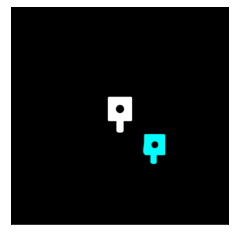

In [551]:
# Save and show Image
result_name = 'result'
# name the file
plt.imshow(get_img(size=[448, 448], name = result_name))    # save the file
plt.xticks([]);plt.yticks([])
plt.show()

tmpdir.cleanup()